In [1]:
import sim
import util
from IPython.display import clear_output

clear_output()

#### Model Imports

In [113]:
import numpy as np
import pyro
import pyro.distributions as dist
import torch
import torch.nn.functional as F
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam
from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

#### Synthetic Data

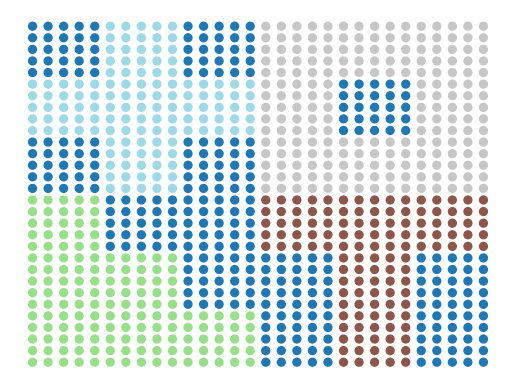

In [2]:
N_GENES = 1000
N_INFORMATIVE = 1000
N_CELLS = 1
N_TOPICS = 5
BLOCKS = sim.GGBLOCKS
MODE = 'block'
MIXED = False

X, X_labels = sim.generate_dataset(N_GENES, N_INFORMATIVE, N_CELLS, N_TOPICS, BLOCKS, MODE, MIXED)
util.visualize_dataset(X, X_labels, size=32, show_ax=False)

#### Basic VAE

In [121]:
def activation(act='softplus', **kwargs):
    if act == 'softplus':
        return nn.Softplus(**kwargs)
    elif act == 'relu':
        return nn.ReLU(**kwargs)
    elif act == 'sigmoid':
        return nn.Sigmoid(**kwargs)
    elif act == 'softmax':
        return nn.Softmax(dim=-1)
    raise NotImplementedError(f'Activation function"{act}" not supported.')

def mlp(layers, bias=True, act='softplus', final_act=None, batch_norm=True, affine=True, dropout=0.):
    n_layers = len(layers) - 1
    for i in range(1, n_layers + 1):
        yield nn.Linear(layers[i - 1], layers[i], bias=bias)
        if i < n_layers:
            yield activation(act if i < n_layers else final_act)
        else:
            if batch_norm:
                yield nn.BatchNorm1d(layers[i], affine=affine)
            if final_act:
                yield activation(final_act)
            yield nn.Dropout(dropout)

class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.loc_net(y)).exp()
        return z_loc, z_scale

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        layers = (latent_dim, hidden_dim, output_dim)
        self.net = nn.Sequential(*list(mlp(layers)))
    
    def forward(self, z):
        x = self.net(z)
        return x
    
class Categorical(dist.Categorical):
    def sample(self, sample_shape=torch.Size()):
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        probs_2d = self.probs.reshape(-1, self._num_events)
        samples_2d = torch.multinomial(probs_2d, sample_shape.numel(), True).T
        return samples_2d.reshape(self._extended_shape(sample_shape)).to(torch.float32)
    
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, scale=.1):
        super().__init__()
        self.latent_dim = latent_dim
        self.scale = scale
        self.encoder = VAEEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VAEDecoder(latent_dim, hidden_dim, input_dim)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.latent_dim))
            z_scale = x.new_ones((x.shape[0], self.latent_dim))
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            x_loc = self.decoder(z)
            x_scale = self.scale*torch.ones_like(x_loc)
            pyro.sample('obs', dist.Normal(x_loc, x_scale).to_event(1), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = Trace_ELBO(max_iarange_nesting=4)
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        z_loc, z_scale = self.encoder(X)
        z = dist.Normal(z_loc, z_scale).sample()
        return z

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:52<00:00, 19.11it/s]


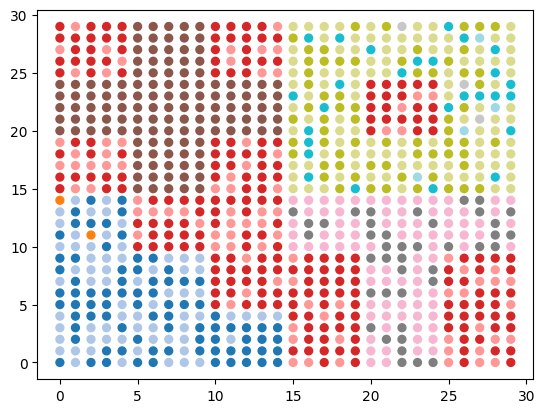

In [75]:
INPUT_DIM = X.shape[1]
LATENT_DIM = 1
HIDDEN_DIM = (X.shape[1] + LATENT_DIM)//2
SCALE = 1e-2
N_STEPS = 1000
LEARNING_RATE = 1e-1

pyro.clear_param_store()

Y = torch.tensor(X, dtype=torch.float32)
model = VAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, SCALE).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels = model.transform(Y)
util.visualize_dataset(X, Y_labels)

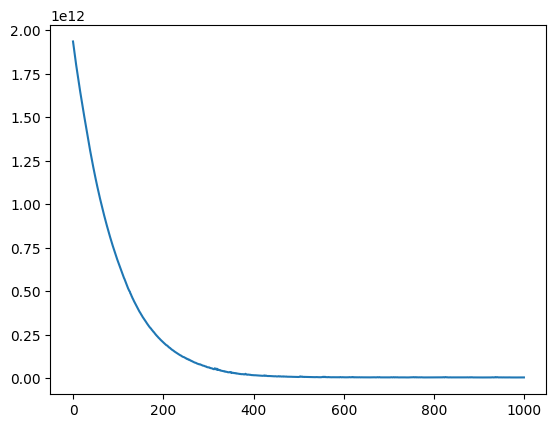

In [76]:
util.visualize_log(model.loss_log_)

#### VAE Topic Model

In [146]:
def count(x, vocab_size):
    x_counts = torch.zeros((x.shape[0], vocab_size))
    for i in range(x.shape[0]):
        idx, counts = torch.unique(x[i], return_counts=True)
        for j in range(idx.shape[0]):
            x_counts[i, idx[j].to(torch.int32)] = counts[j].to(torch.int32)
    return x_counts

def build(x, n_words, vocab_size, vocab_steps=10, return_counts=False):
    codebook, _ = kmeans(x[:, 2:], vocab_size, vocab_steps)
    neighbors = NearestNeighbors(n_neighbors=n_words).fit(x)
    _, neighbor_idx = neighbors.kneighbors(x)
    data = np.zeros((x.shape[0], n_words), dtype=np.int32)
    for i in range(x.shape[0]):
        data[i], _ = vq(x[neighbor_idx, 2:][i], codebook)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    if return_counts:
        return data_tensor, count(data_tensor, vocab_size)
    return data_tensor

class VAETMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers, affine=True)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers, affine=True)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.scale_net(y)).exp()
        return z_loc, z_scale

class VAETMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        layers = (latent_dim, hidden_dim, output_dim)
        self.dropout = nn.Dropout(.2)
        self.net = nn.Sequential(*list(mlp(layers, bias=False, final_act='softmax', affine=True)))
    
    def forward(self, z):
        y = self.dropout(z)
        x = self.net(y)
        return x
    
class VAETM(nn.Module):
    def __init__(self, n_topics, n_words, vocab_size, hidden_dim):
        super().__init__()
        self.n_topics = n_topics
        self.n_words = n_words
        self.encoder = VAETMEncoder(vocab_size, hidden_dim, n_topics)
        self.decoder = VAETMDecoder(n_topics, hidden_dim, vocab_size)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.n_topics))
            z_scale = x.new_ones((x.shape[0], self.n_topics))
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            probs = self.decoder(z)
            pyro.sample('obs', dist.Multinomial(self.n_words, probs), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        dists_loc, dists_scale = self.encoder(X)
        dists = dist.Normal(dists_loc, dists_scale).sample()
        return dists

In [106]:
N_WORDS = 15
VOCAB_SIZE = 25

_, Y = build(X, N_WORDS, VOCAB_SIZE, return_counts=True)

100%|██████████| 1000/1000 [00:11<00:00, 88.61it/s]


Score: 0.5211111111111111


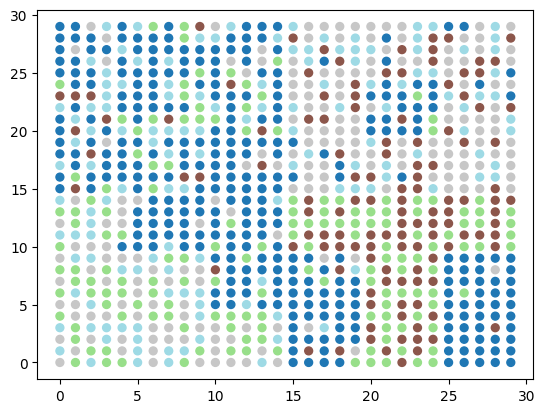

In [143]:
HIDDEN_DIM = (VOCAB_SIZE + N_TOPICS)//2
N_STEPS = 1000
LEARNING_RATE = 1e-1

pyro.clear_param_store()

model = VAETM(N_TOPICS, N_WORDS, VOCAB_SIZE, HIDDEN_DIM).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform(Y).argmax(-1))
print('Score:', score)
util.visualize_dataset(X, Y_labels)

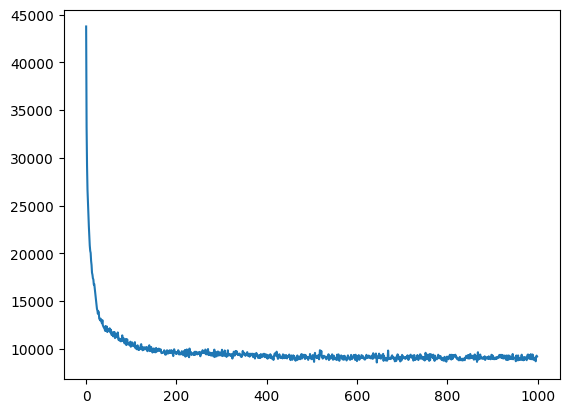

In [144]:
util.visualize_log(model.loss_log_)

#### ProdVAE Topic Model

In [149]:
class PVAETMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers, affine=True)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers, affine=True)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.scale_net(y)).exp()
        return z_loc, z_scale

class PVAETMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        layers = (latent_dim, hidden_dim, output_dim)
        self.dropout = nn.Dropout(.2)
        self.net = nn.Sequential(*list(mlp(layers, bias=False, final_act='softmax', affine=True)))
    
    def forward(self, z):
        y = self.dropout(z)
        x = self.net(y)
        return x
    
class PVAETM(nn.Module):
    def __init__(self, n_topics, n_words, vocab_size, hidden_dim):
        super().__init__()
        self.n_topics = n_topics
        self.n_words = n_words
        self.encoder = VAETMEncoder(vocab_size, hidden_dim, n_topics)
        self.decoder = VAETMDecoder(n_topics, hidden_dim, vocab_size)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.n_topics))
            z_scale = x.new_ones((x.shape[0], self.n_topics))
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            probs = self.decoder(z)
            pyro.sample('obs', dist.Multinomial(self.n_words, probs), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        dists_loc, dists_scale = self.encoder(X)
        dists = dist.Normal(dists_loc, dists_scale).sample()
        return dists

In [147]:
N_WORDS = 15
VOCAB_SIZE = 25

_, Y = build(X, N_WORDS, VOCAB_SIZE, return_counts=True)

100%|██████████| 1000/1000 [00:11<00:00, 84.40it/s]


Score: 0.5644444444444444


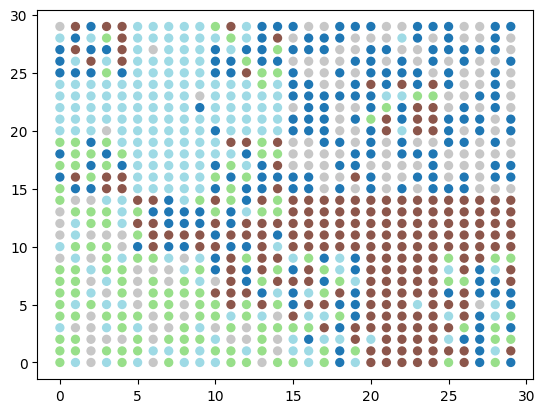

In [150]:
HIDDEN_DIM = (VOCAB_SIZE + N_TOPICS)//2
N_STEPS = 1000
LEARNING_RATE = 1e-1

pyro.clear_param_store()

model = PVAETM(N_TOPICS, N_WORDS, VOCAB_SIZE, HIDDEN_DIM).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform(Y).argmax(-1))
print('Score:', score)
util.visualize_dataset(X, Y_labels)

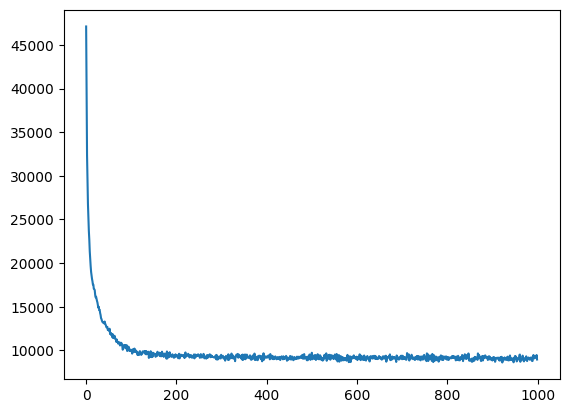

In [151]:
util.visualize_log(model.loss_log_)

#### Prototypical Neural Topic Model

In [152]:
class NTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.scale_net(y)).exp()
        return z_loc, z_scale

class NTMDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        layers = (latent_dim, output_dim)
        self.dropout = nn.Dropout(.2)
        self.net = nn.Sequential(*list(mlp(layers, bias=False, final_act='softmax', affine=False)))
    
    def forward(self, z):
        y = self.dropout(z)
        x = self.net(y)
        return x
    
class NTM(nn.Module):
    def __init__(self, n_topics, n_words, vocab_size, hidden_dim):
        super().__init__()
        self.n_topics = n_topics
        self.n_words = n_words
        self.encoder = NTMEncoder(vocab_size, hidden_dim, n_topics)
        self.decoder = NTMDecoder(n_topics, vocab_size)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.n_topics))
            z_scale = x.new_ones((x.shape[0], self.n_topics))
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            probs = self.decoder(z)
            pyro.sample('obs', dist.Multinomial(self.n_words, probs), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        dists = X@self.decoder.net[0].weight
        return dists

In [134]:
N_WORDS = 15
VOCAB_SIZE = 25

_, Y = build(X, N_WORDS, VOCAB_SIZE, return_counts=True)

100%|██████████| 1000/1000 [00:09<00:00, 106.26it/s]


Score: 0.8333333333333334


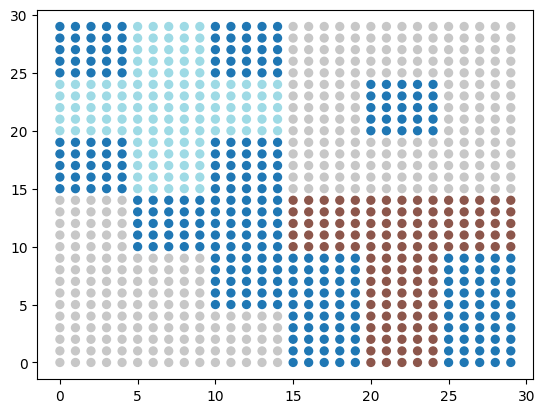

In [162]:
HIDDEN_DIM = (VOCAB_SIZE + N_TOPICS)//2
N_STEPS = 1000
LEARNING_RATE = 1e-3

pyro.clear_param_store()

model = NTM(N_TOPICS, N_WORDS, VOCAB_SIZE, HIDDEN_DIM).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform(Y).argmax(-1))
print('Score:', score)
util.visualize_dataset(X, Y_labels)

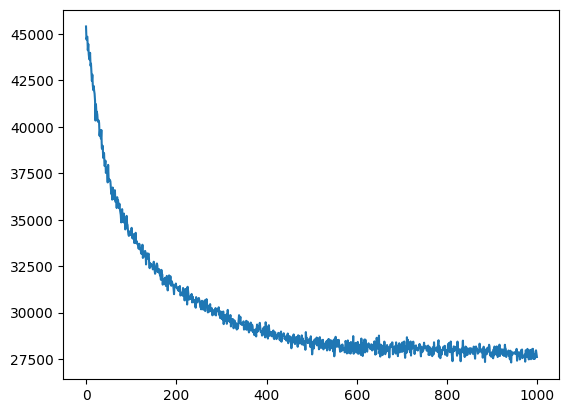

In [163]:
util.visualize_log(model.loss_log_)

#### Product of Experts Topic Model

In [167]:
class PNTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.scale_net(y)).exp()
        return z_loc, z_scale

class PNTMDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        layers = (latent_dim, output_dim)
        self.dropout = nn.Dropout(.2)
        self.net = nn.Sequential(*list(mlp(layers, bias=False, final_act='softmax', affine=False)))
    
    def forward(self, z):
        y = self.dropout(z)
        x = self.net(y)
        return x
    
class PNTM(nn.Module):
    def __init__(self, n_topics, n_words, vocab_size, hidden_dim):
        super().__init__()
        self.n_topics = n_topics
        self.n_words = n_words
        self.encoder = PNTMEncoder(vocab_size, hidden_dim, n_topics)
        self.decoder = PNTMDecoder(n_topics, vocab_size)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.n_topics))
            z_scale = x.new_ones((x.shape[0], self.n_topics))
            z = F.softmax(pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1)), -1)
            probs = self.decoder(z)
            pyro.sample('obs', dist.Multinomial(self.n_words, probs), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        dists = X@self.decoder.net[0].weight
        return dists

In [110]:
N_WORDS = 15
VOCAB_SIZE = 25

_, Y = build(X, N_WORDS, VOCAB_SIZE, return_counts=True)

100%|██████████| 1000/1000 [00:10<00:00, 98.94it/s]


Score: 1.0


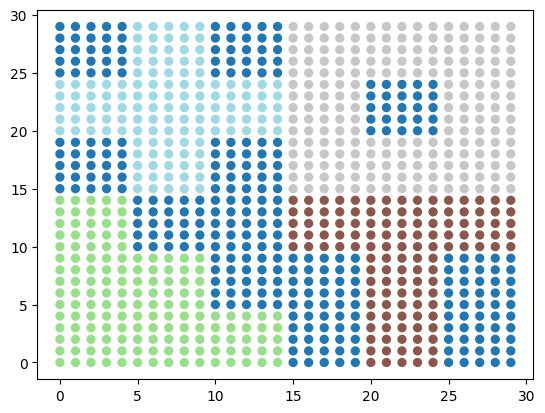

In [168]:
HIDDEN_DIM = (VOCAB_SIZE + N_TOPICS)//2
N_STEPS = 1000
LEARNING_RATE = 1e-3

pyro.clear_param_store()

model = PNTM(N_TOPICS, N_WORDS, VOCAB_SIZE, HIDDEN_DIM).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform(Y).argmax(-1))
print('Score:', score)
util.visualize_dataset(X, Y_labels)

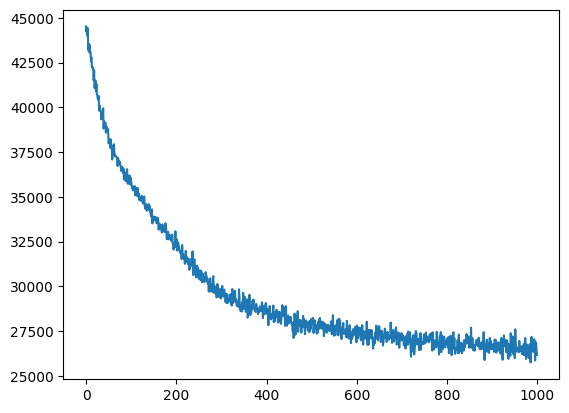

In [169]:
util.visualize_log(model.loss_log_)

#### Gaussian Softmax Topic Model

In [173]:
class GSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.scale_net(y)).exp()
        return z_loc, z_scale

class GSTMDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        layers = (latent_dim, output_dim)
        self.dropout = nn.Dropout(.2)
        self.net = nn.Sequential(*list(mlp(layers, bias=False, final_act='softmax', affine=False)))
    
    def forward(self, z):
        y = self.dropout(z)
        x = self.net(y)
        return x
    
class GaussianSoftmax(dist.Normal):
    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            return F.softmax(torch.normal(self.loc.expand(shape), self.scale.expand(shape)), dim=-1)
    
class GSTM(nn.Module):
    def __init__(self, n_topics, n_words, vocab_size, hidden_dim):
        super().__init__()
        self.n_topics = n_topics
        self.n_words = n_words
        self.encoder = GSTMEncoder(vocab_size, hidden_dim, n_topics)
        self.decoder = GSTMDecoder(n_topics, vocab_size)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.n_topics))
            z_scale = x.new_ones((x.shape[0], self.n_topics))
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            probs = self.decoder(z)
            pyro.sample('obs', dist.Multinomial(self.n_words, probs), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', GaussianSoftmax(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        dists = X@self.decoder.net[0].weight
        return dists

In [171]:
N_WORDS = 15
VOCAB_SIZE = 25

_, Y = build(X, N_WORDS, VOCAB_SIZE, return_counts=True)

100%|██████████| 1000/1000 [00:10<00:00, 99.01it/s]


Score: 0.8322222222222222


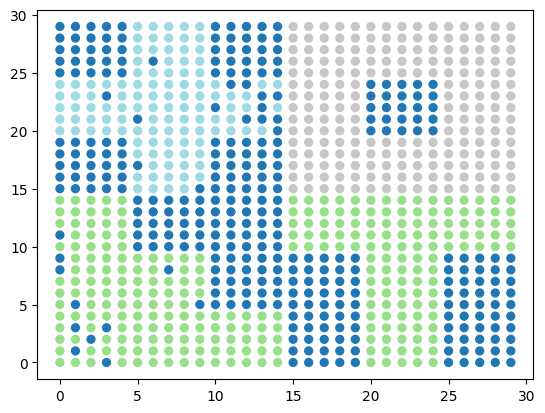

In [174]:
HIDDEN_DIM = (VOCAB_SIZE + N_TOPICS)//2
N_STEPS = 1000
LEARNING_RATE = 1e-3

pyro.clear_param_store()

model = GSTM(N_TOPICS, N_WORDS, VOCAB_SIZE, HIDDEN_DIM).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform(Y).argmax(-1))
print('Score:', score)
util.visualize_dataset(X, Y_labels)

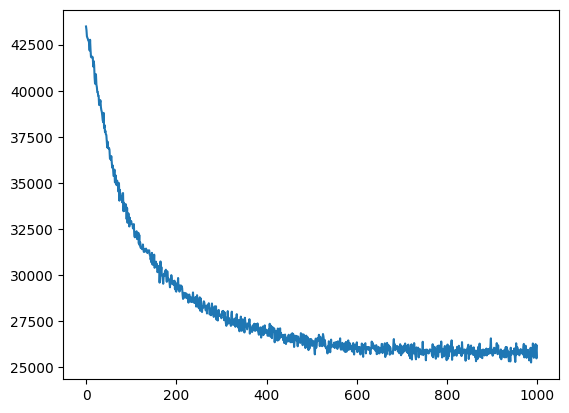

In [175]:
util.visualize_log(model.loss_log_)

#### Product of Experts Gaussian Softmax Topic Model

In [179]:
class PGSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        encoding_layers = (input_dim, hidden_dim, hidden_dim)
        latent_layers = (hidden_dim, latent_dim)
        self.encoding_net = nn.Sequential(*list(mlp(encoding_layers, final_act='softplus', batch_norm=False, dropout=.2)))
        self.loc_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))
        self.scale_net = nn.Sequential(*list(mlp(latent_layers, affine=False)))

    def forward(self, x):
        y = self.encoding_net(x)
        z_loc = self.loc_net(y)
        z_scale = (.5*self.scale_net(y)).exp()
        return z_loc, z_scale

class PGSTMDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        layers = (latent_dim, output_dim)
        self.dropout = nn.Dropout(.2)
        self.net = nn.Sequential(*list(mlp(layers, bias=False, final_act='softmax', affine=False)))
    
    def forward(self, z):
        y = self.dropout(z)
        x = self.net(y)
        return x
    
class PGaussianSoftmax(dist.Normal):
    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            return F.softmax(torch.normal(self.loc.expand(shape), self.scale.expand(shape)), dim=-1)
    
class PGSTM(nn.Module):
    def __init__(self, n_topics, n_words, vocab_size, hidden_dim):
        super().__init__()
        self.n_topics = n_topics
        self.n_words = n_words
        self.encoder = PGSTMEncoder(vocab_size, hidden_dim, n_topics)
        self.decoder = PGSTMDecoder(n_topics, vocab_size)
        self.loss_log_ = []

    def _model(self, x):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros((x.shape[0], self.n_topics))
            z_scale = x.new_ones((x.shape[0], self.n_topics))
            z = F.softmax(pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1)), dim=-1)
            probs = self.decoder(z)
            pyro.sample('obs', dist.Multinomial(self.n_words, probs), obs=x)

    def _guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', GaussianSoftmax(z_loc, z_scale).to_event(1))

    def fit(self, X, n_steps=100, learning_rate=1e-2):
        optim = Adam({'lr': learning_rate})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self._model, self._guide, optim, elbo)
        for _ in tqdm(range(n_steps)):
            loss = svi.step(X)
            self.loss_log_.append(loss)
        return self
    
    def transform(self, X):
        dists = X@self.decoder.net[0].weight
        return dists

In [177]:
N_WORDS = 15
VOCAB_SIZE = 25

_, Y = build(X, N_WORDS, VOCAB_SIZE, return_counts=True)

100%|██████████| 1000/1000 [00:09<00:00, 102.45it/s]


Score: 1.0


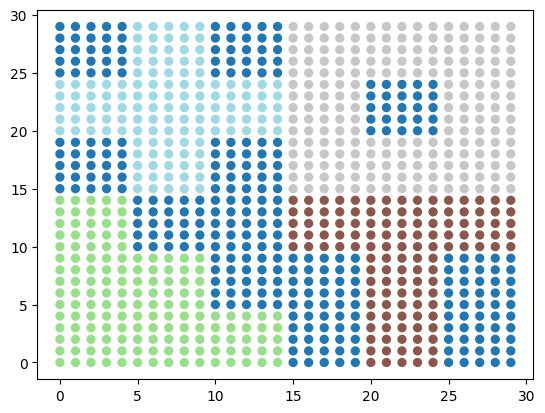

In [182]:
HIDDEN_DIM = (VOCAB_SIZE + N_TOPICS)//2
N_STEPS = 1000
LEARNING_RATE = 1e-3

pyro.clear_param_store()

model = PGSTM(N_TOPICS, N_WORDS, VOCAB_SIZE, HIDDEN_DIM).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform(Y).argmax(-1))
print('Score:', score)
util.visualize_dataset(X, Y_labels)

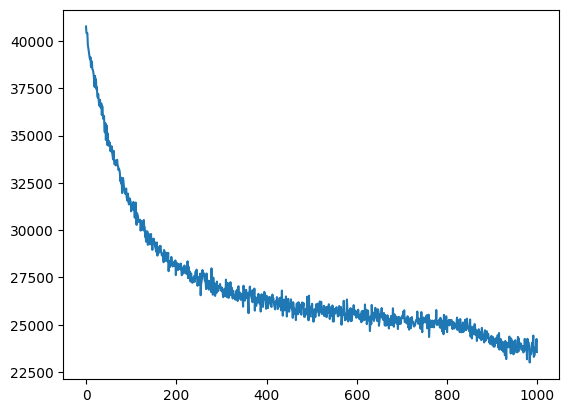

In [183]:
util.visualize_log(model.loss_log_)